# Fontvolve-TensorFlow
*[Website](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/fontvolve-TF.ipynb)*

Fontvolve is an evolutionary algorithm that attempts the 'Font Problem' - that is, how to capture the essence of a font in such a way as to generalise to unseen glyphs and to allow interpolation between different fonts or extrapolation of a full font from a few example letters.  This problem was noted as early as 1979 when Donald Knuth wrote the first version of [MetaFont](https://en.wikipedia.org/wiki/Metafont).

An initial implementation using python lists with the Python Image library for rendering suffered poor performance and inability to multithread.  This version uses [Tensorflow](https://www.tensorflow.org/) to address these issues.  

The evolutionary algorithm will operate on a gene representing the [glyph outlines](https://en.wikipedia.org/wiki/Glyph), expressed as (dx, dy) pairs for each line as in [Turtle graphics](https://en.wikipedia.org/wiki/Turtle_graphics) (best known for its  use in [Logo](https://en.wikipedia.org/wiki/Logo_(programming_language).)  We do not currently model the bezier curves used in the original glyphs, but allow the output to match the curve with a set of smaller straight lines.  As input to the algorithm, we convert rendered images to Tensorflow tensors.

Considering the [loss](https://en.wikipedia.org/wiki/Loss_function) or evaluation function we note that the exact sequence of points in the glyph can be varied while generating identical rendered output, for example a line segment can be split into a number of smaller colinear segments.  The network should be free to express its results in any equivalent way.  The evaluation function is therefore required to compare rendered output not the exact series of doubles that generate the baseline.  We build an evaluation function in pure Tensorflow using a [scanline algorithm](https://en.wikipedia.org/wiki/Scanline_rendering) to generate a tensor containing the x coordinates of the outline for a set of equi-spaced y line. The predicted and true outlines are then compared by calculating the difference in these coordinates. This is an fairly unstable measure; to give the initial genes a good starting point we initial them to a random number of points arranged in a circle.

See also:
* [MetaFont](https://en.wikipedia.org/wiki/Metafont)
* [Metaflop - interactive MetaFont](http://www.metaflop.com/modulator)
* [deepfont](https://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks.html)
* https://arxiv.org/abs/1507.03196
* https://pypi.python.org/pypi/FontTools


In [1]:
from enum import Enum, IntEnum
import math
import os
import glob
from random import random, randint, choice, seed
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
import tensorflow as tf
from fontTools.ttLib import TTFont  # pip install fonttools
np.set_printoptions(2)
print('np',np.__version__)
print('tf',tf.__version__)

np 1.13.3
tf 1.4.0


In [12]:
def render_glyphs(gls, max_points_per_line, ygrid):
    """
    Pure tensorflow function
    Input: 2D tensor of glyph * outlines (either x,y or angle, distance pairs)
    Output: glyph * matrix of sorted x coords for each line per y coording
    """
    dxs = gls[:,:,LastDim.DX]
    dys = gls[:,:,LastDim.DY]
    xs = tf.cumsum(dxs, axis=-1)+1e-2
    ys = tf.cumsum(dys, axis=-1)+1e-2
    visible = tf.logical_or(xs[:, 1:]>0, ys[:, 1:]>0)
        
    # offset to create line start x1,y1 to end x2,y2
    x1s = xs[:,:-1]
    x2s = xs[:,1:]
    y1s = ys[:,:-1]
    y2s = ys[:,1:]
    # add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    xx1s=tf.expand_dims(x1s,-1)
    xx2s=tf.expand_dims(x2s,-1)
    yy1s=tf.expand_dims(y1s,-1)
    yy2s=tf.expand_dims(y2s,-1)
    # interpolate the x coords for all lines at all y coord
    xxs = xx1s + (xx2s-xx1s)*(ygrid-yy1s)/(yy2s-yy1s)
    # zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(yy1s<ygrid, ygrid<=yy2s), tf.logical_and(yy2s<ygrid, ygrid<=yy1s))
    in_range = tf.logical_and(in_range, yy2s!=yy1s)
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0, 2, 1)), max_points_per_line).values

In [13]:
def get_glyph_coordinates(font, glyphName:str):
    """
    font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours


def read_fonts(glyphs, max_outline_points, ygrid):
    glyphinputs = np.identity(len(glyphs), dtype=float)  # input is one-hot vec, one per glyph
    files = glob.glob('deeper\Courier*.ttf')
    if not files:
        files = glob.glob(r'C:\src\notebooks\deeper\Courier*.ttf')
    print('loading {} files: {}'.format(len(files), files))
    inputs = []
    outlines = []
    for i, fontfile in enumerate(files):
        print('loading {}'.format(fontfile))
        fontvec = np.zeros(len(files))
        fontvec[i] = 1
        inputs.append(np.concatenate((glyphinputs, np.broadcast_to(fontvec, (glyphinputs.shape[0], fontvec.shape[0]))), axis=1))
        outlines.append(generate_outlines(fontfile, glyphs, max_outline_points, ygrid))
    return np.concatenate(inputs), np.concatenate(outlines)


class LastDim(IntEnum):
    """
    Enum defining last dimension
    """
    DX = 0
    DY = 1
    Show = 2  # +1 draw, -1 if this line is hidden, i.e. between contours in the glyph
    Active = 3  # >0 == further points in outline
    Last_dim_size = 4
    
    
def generate_outlines(fontfile:str, glyphs:str):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    font = TTFont(fontfile)
    units_per_em = font['head'].unitsPerEm * 0.9
    numglyphs = len(glyphs)
    outlines = np.zeros((numglyphs, max_outline_points, LastDim.Last_dim_size), np.float32)
    for i, letter in enumerate(glyphs):
        contours = get_glyph_coordinates(font, letter)
        j = 0
        startp = (0,0.1)
        # ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for xy in contours:
            # fill output matrix, start with hidden line to start position
            outlines[i,j,LastDim.DX] = (xy[0][0]-startp[0]) / units_per_em
            outlines[i,j,LastDim.DY] = (xy[0][1]-startp[1]) / units_per_em
            outlines[i,j,LastDim.Show] = 0
            j = j+1
            if j>=max_outline_points: break
            startp = xy[0]
            # then between points
            for n in range(len(xy)-1):
                outlines[i,j,LastDim.DX] = (xy[n+1][0]-xy[n][0])/ units_per_em
                outlines[i,j,LastDim.DY] = (xy[n+1][1]-xy[n][1])/ units_per_em
                outlines[i,j,LastDim.Show] = 1
                j = j+1
                if j>=max_outline_points: break
            if j>=max_outline_points: break
            # finally wrap last point to first in contour
            N=len(xy)-1
            outlines[i,j,LastDim.DX] = (xy[0][0]-xy[N][0])/ units_per_em
            outlines[i,j,LastDim.DY] = (xy[0][1]-xy[N][1])/ units_per_em
            outlines[i,j,LastDim.Show] = 1
            j = j+1
            if j >= max_outline_points: break
        outlines[i, :j, LastDim.Active] = 1
    return outlines

In [14]:
def draw_outlines(outlines, cellsize):
    """
    Draw numpy array interpreted as a glyph per row and each row containing x,y or angle,dist pairs.
    """
    columns = math.ceil(800/cellsize)
    rows = math.ceil(outlines.shape[0]/columns)
    
    def draw_points(im, points, cellx, celly):
        # temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(outlines.shape[0]):
        celly, cellx = divmod(i, columns)
        cellx *= cellsize
        celly *= cellsize
        points = []
        x, y = (0, cellsize-1)
        for j in range(outlines.shape[1]):
            if outlines[i][j][LastDim.Active] < 0.5: 
                break;
            x += outlines[i][j][LastDim.DX]*scale
            y -= outlines[i][j][LastDim.DY]*scale
            if outlines[i][j][LastDim.Show] > 0.5:
                points += (cellx+x,celly+y)
            elif len(points) > 2:
                im = draw_points(im, points, cellx, celly)
                points=[]
        if len(points) > 2:
            im = draw_points(im, points, cellx, celly)
    return im


def draw_xys(xxs, ygrid, cellsize):
    """
    Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord
    """
    columns = math.ceil(800/cellsize)
    rows = math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
        yy,xx = divmod(i, columns)
        xx *= cellsize
        yy = (yy+1)*cellsize-1
        for xs, y in zip(xxs[i], ygrid):
            for x in xs:
                if x>0.0:
                    draw.ellipse((xx+x*scale, yy-y*scale, xx+x*scale+3, yy-y*scale+3), fill=1)
    return im

setup...


outline shape:  (62, 110, 4)


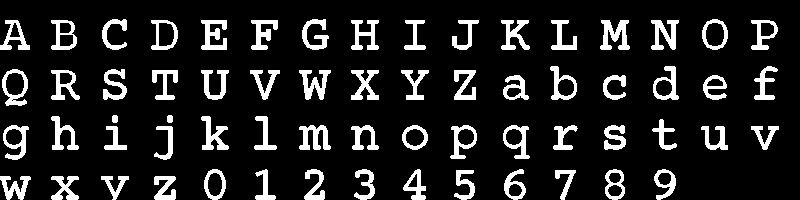

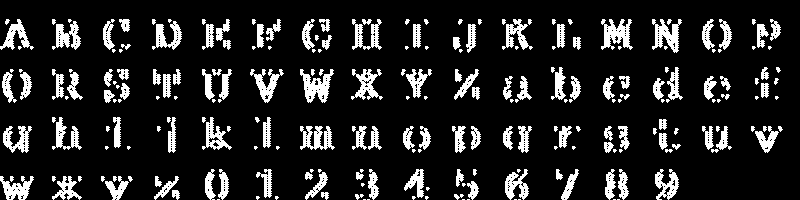

In [18]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
max_points_per_line = 10 # required for g, m
max_outline_points = 110
y_divisions = 20
ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False)  # y coordinates to render on
#inputs, outlines = read_fonts(glyphs, max_outline_points, ygrid)
outlines = generate_outlines('deeper/Courier Prime.ttf', glyphs)
with tf.Session() as sess:
    xcoords = render_glyphs(outlines, max_points_per_line, ygrid).eval()
batch_size=outlines.shape[0]
print("outline shape: ", outlines.shape)
cellsize = 50
#draw_outlines(outlines, cellsize)
display(draw_outlines(outlines, cellsize), draw_xys(xcoords, ygrid, cellsize))

In [21]:
pool_size = 200

target = np.zeros((1, outlines.shape[1], outlines.shape[2]))
target[:] = outlines[26+ord('o')-ord('a')]  # target letter 'b'
with tf.Session() as sess:
    target_coords = render_glyphs(target, max_points_per_line, ygrid).eval()
print(target_coords[0])
seed(1)
orig_pool = np.zeros((pool_size, outlines.shape[1], outlines.shape[2]))
orig_pool[:] = outlines[26]  # start with letter 'a'
print(orig_pool.shape)


[[ 0.41  0.28  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.51  0.17  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.56  0.44  0.25  0.12  0.    0.    0.    0.    0.    0.  ]
 [ 0.59  0.49  0.19  0.1   0.    0.    0.    0.    0.    0.  ]
 [ 0.61  0.52  0.17  0.08  0.    0.    0.    0.    0.    0.  ]
 [ 0.61  0.53  0.16  0.08  0.    0.    0.    0.    0.    0.  ]
 [ 0.61  0.53  0.16  0.08  0.    0.    0.    0.    0.    0.  ]
 [ 0.6   0.51  0.18  0.09  0.    0.    0.    0.    0.    0.  ]
 [ 0.58  0.47  0.22  0.11  0.    0.    0.    0.    0.    0.  ]
 [ 0.53  0.15  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.46  0.23  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  

In [33]:

def evolve(pool: tf.Tensor, debug=False) -> (tf.Tensor, float):
    """
    The gene pool is represented as a 3D tensor: the first dimension (row) corresponds to different genes each giving 
    rise to an organism (font), the second dimension (column) represents multiple bases giving each step in a font 
    outline, the third dimension is a vector of dx, dy, draw and end components.

    We evolve our population with differential selection, combination and copy and insert/delete mutations.  To 
    propagate genes differentially based on fitness, we pick a new population by sampling a distribution with 
    probability for each gene.  This is calculated as the normalised fitness using the TensorFlow Categorical 
    distribution which gives a category index as the result of each sample which we use as the first index to gather 
    from the gene pool tensor.

    To apply insert/delete mutations, we build a set of indices initialised to to the identity function, perturbed with 
    a cummulative random normal rounded to a integer offset.  For example 
    the rounded random normal vector [0, 0, 1, 0, 2, -1, 0], 
    accumulated gives [0, 0, 1, 1, 3, 2, 2], 
    and added to the identity vector [0, 1, 2, ...] 
    gives [0, 1, 3, 4, 7, 7, 8] which we use as the second index into the gene pool tensor.  
    This supports mutations of adding and deleting bases from the gene, with a probability proportional to the standard 
    deviation of the random normals.

    For gene combination we apply a similar cummulative random normal offset to the Categorical distribution indices, 
    which has the effect of switching the selected gene (row).  As the gene rows are unsorted, this will pick successive 
    bases from a likely different neighbouring gene.

    Finally, to implement base copying mutations we choose a small set of tensor indices to offset with a random normal.
    
    :param pool: gene pool as 3D tensor 
    :param debug:  flag to display partial results
    :return: pair of new gene pool and a max score for tracking progress
    """
    
    copy_mutation_sd = 1e-3
    base_mutation_rate = 1e-2

    if debug:
        print('pool', pool.shape)
    if isinstance(pool.shape, tf.TensorShape):
        dims = [d.value for d in pool.shape]
    else:  # np.ndarray
        dims = pool.shape
    xcoords = render_glyphs(pool, max_points_per_line, ygrid)
    scores = 1e3 / tf.reduce_sum(tf.square(xcoords-target_coords), axis=(1, 2))
    norm_scores = scores - tf.reduce_min(scores) +1e-6
    norm_scores2 = norm_scores / tf.reduce_sum(norm_scores)
    dist = tf.distributions.Categorical(probs=norm_scores2)
    new_pop_indices = dist.sample(pool.shape[0], seed=1)
    if debug:
        #print('xcoords', xcoords.eval())
        #print('target', target_coords)
        #print('x-target', (xcoords-target_coords).eval())
        print('score', scores.eval(), tf.reduce_min(scores).eval(), tf.reduce_min(scores).eval())
        print('norm_scores', norm_scores.eval())
        print('norm_scores2', norm_scores2.eval())
    norms0 = tf.distributions.Normal(0.0, copy_mutation_sd).sample(pool.shape[0:2], seed=1)
    row_offsets = tf.cumsum(tf.cast(tf.round(norms0), tf.int32), axis=1)
    row_indices = tf.clip_by_value(tf.add(tf.reshape(new_pop_indices, (-1, 1)), row_offsets), 0, pool.shape[0]-1)
    # note eval-ing a sample gives different values each time; new samples are drawn
    # print('row_offsets', row_offsets.shape, '\n', row_offsets.eval()[0:3, 0:12], '\n', row_indices.eval()[0:3, 0:12])
    norms1 = tf.distributions.Normal(1.0, copy_mutation_sd).sample(pool.shape[0:2], seed=1)
    column_indices = tf.clip_by_value(tf.cumsum(tf.cast(tf.round(norms1), tf.int32), axis=1), 0, pool.shape[1])-1
    indices = tf.stack((row_indices, column_indices), axis=-1)
    # print('indices', indices.eval())
    new_pool = tf.gather_nd(pool, indices)
    mutations = int(np.prod(dims) * base_mutation_rate)
    mutation_rows = tf.cast(tf.distributions.Uniform(0.0, float(dims[0]) - 1e-6).sample(mutations, seed=1), tf.int32)
    mutation_cols = tf.cast(tf.distributions.Uniform(0.0, float(dims[1]) - 1e-6).sample(mutations, seed=1), tf.int32)
    mutations_index3 = tf.cast(tf.distributions.Uniform(0.0, float(dims[2])-1e-6).sample(mutations, seed=1), tf.int32)
    mutation_indices = tf.stack((mutation_rows, mutation_cols, mutations_index3), axis=-1)
    mutation_amounts = tf.distributions.Normal(0.0, 0.1).sample(mutations, seed=1)
    mutation_tensor = tf.scatter_nd(mutation_indices, mutation_amounts, pool.shape)
    # print('mutation_indices', mutation_indices.eval(), mutation_amounts.eval(), mutation_tensor.eval())
    return new_pool + mutation_tensor, tf.reduce_max(scores)


gene_pool = orig_pool.astype(np.float32)
debug = True
if debug:
    with tf.Session() as sess:
        print('orig', orig_pool[0, 0:5])
        gene_pool = gene_pool[0:5]
        gene_pool, maxscore = evolve(gene_pool, True)
        gene_pool, maxscore = evolve(gene_pool, True)
else:
    generations = gene_pool[0:1]
    tf_input = tf.placeholder(tf.float32, orig_pool.shape, 'pool')
    tf_evolve = evolve(tf_input)
    with tf.Session() as sess:
        #print('orig', orig_pool[0, 0:5])
        for gen in range(0, 5):
            for i in range(0, 5):
                # debug
                # evolve(gene_pool)
                
                gene_pool, max_score = sess.run(tf_evolve, {tf_input: gene_pool})
                # print(gene_pool[0, 0:5])
            print(gen, max_score)
            #print('last', gene_pool[0, 0:5].eval())
            generations = np.append(generations, gene_pool[0:1], axis=0)
    
    draw_outlines(generations, cellsize, scheme)

orig [[ 0.59  0.07  0.    1.  ]
 [ 0.02  0.    1.    1.  ]
 [ 0.02 -0.02  1.    1.  ]
 [ 0.   -0.02  1.    1.  ]
 [ 0.   -0.02  1.    1.  ]]
pool (5, 110, 4)


score [ 1071.03  1071.03  1071.03  1071.03  1071.03] 1071.03 1071.03
norm_scores [  1.00e-06   1.00e-06   1.00e-06   1.00e-06   1.00e-06]
norm_scores2 [ 0.2  0.2  0.2  0.2  0.2]
pool

 (5, 110, 4)
score [  417.22   369.62   468.45  1071.03  1071.03] 166.166 91.3954
norm_scores [  1.94e+02   1.00e-06   4.64e+00   7.74e+02   7.74e+02]
norm_scores2 [  7.53e-02   5.09e-10   1.47e-01   3.89e-01   3.89e-01]


In [104]:
print('fitting model...')
epochs=1000
logs = 'logs/deeper-p'+str(np.sum([np.prod(t.shape) for t in model.get_weights()]))+'-e'+str(epochs)
print(logs)
print('view using:\ntensorboard --logdir='+os.path.abspath('logs'))
board = TensorBoard(log_dir=logs)

model.fit(inputs, 
          {'scalars':outlines[:,:,0:2], 'showflags':outlines[:,:,2], 'activeflags':outlines[:,:,3]},
          batch_size=outlines.shape[0], epochs=epochs, verbose=0, callbacks=[board], shuffle=False)
scores = model.evaluate(inputs, {'scalars':outlines[:,:,0:2], 'showflags':outlines[:,:,2], 'activeflags':outlines[:,:,3]}, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

fitting model...


NameError: name 'model' is not defined

In [105]:
_scalars, _showflags, _activeflags = model.predict(inputs, verbose=0)
newoutlines = np.concatenate((_scalars, np.expand_dims(_showflags,2), np.expand_dims(_activeflags,2)), axis=2)

NameError: name 'model' is not defined

In [106]:
draw_outlines(newoutlines, cellsize, scheme)

NameError: name 'newoutlines' is not defined

In [107]:
#show raw outputs for first glyph scaled by 100
np.set_printoptions(precision=0)
print(np.reshape(np.stack((outlines[0]*100, newoutlines[0]*100), axis=-1).astype(np.int), (-1, 8)))

NameError: name 'newoutlines' is not defined

In [108]:
#what about interpolating between glyphs?  let's try gradually mixing A into B
#need array [[1, 0, ...], [1, 0.1, ...]]
A = inputs[4]
B = inputs[5]
steps=12
mix = np.array([A*(steps-i)/steps + i*B/steps for i in range(steps+5)])
#print(mix[:3])
interp = model.predict(mix, verbose=1)
draw_outlines(interp, cellsize * 5, scheme)
#not very convincing :(, perhaps raw points rather than angle, dist pairs for the outline would be better
#also need to try interpolating A between two fonts

NameError: name 'model' is not defined

In [109]:
#now, what happens when we predict mixed glyphs?
mixed_outlines = model.predict(np.random.random(inputs.shape), verbose=1)
draw_outlines(mixed_outlines, cellsize, scheme)

NameError: name 'model' is not defined